## Evaluate
* Load the previously trained models
* Load the test data
* Evaluate the accuracy and inference speed of each model

In [12]:
from tensorflow.keras.utils import to_categorical

import numpy as np
from os.path import join
import pickle
import random
import pandas as pd
from matplotlib import pyplot as plt
import time
import keras 
%matplotlib inline

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_TEST_SAMPLES = 1000

# Rescale the data (color) values
scale = False  # rather not

# number of times the accuracy tests should be repeated
NUM_TESTS = 10

## Test data
Load the data prepared in previous notebook

In [14]:
with np.load(join(DATA_PATH, 'test_data.npz')) as data:
    data_dict=dict(data.items())
X_test = data_dict['X']
y_test = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [15]:
# Get a smaller random sample 
def sample_test_data():
    idx = random.sample(range(len(X_test)-1), NUM_TEST_SAMPLES)
    X_test_sub = X_test[idx]
    y_test_sub = y_test[idx]    
    return X_test_sub, y_test_sub

## Test accuracy
Test accuracy on test dataset for different models trained in previous notebooks

In [6]:
# define results matrix
eval_pd = pd.DataFrame(columns=['model', 'accuracy', 'CPU_time'])

### Dummy model
Dummy -most common category- model, used as baseline

In [7]:
with open(join(MODELS_PATH, 'dummy.pickle'), 'rb') as handle:
    dummy = pickle.load(handle)

In [8]:
%%time

model_name = 'dummy'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # Flatten images, as required by dumnmy and SVn models
    X_flat = [img.flatten() for img in X_test_sub]

    start = time.process_time()
    # Compute accuracy on the test set
    accuracy = dummy.score(X_flat, y_test_sub)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

CPU times: user 472 ms, sys: 361 ms, total: 832 ms
Wall time: 850 ms


### ~~SVN~~
~~Support Vector Machine, also applied to flattened images~~

Takes more than 1 h to run, definitely not suitable for real-time classification.

In [9]:
#with open(join(MODELS_PATH, 'pipe_svc.pickle'), 'rb') as handle:
#    svn = pickle.load(handle)

In [ ]:
#%%time

#model_name = 'svn'
#for _ in range(NUM_TESTS):
#    X_test_sub, y_test_sub = sample_test_data()
#    # Flatten images, as required by dumnmy and SVn models
#    X_flat = [img.flatten() for img in X_test_sub]

#    start = time.process_time()
    # Compute accuracy on the test set
#    accuracy = svn.score(X_flat, y_test_sub)
#    dtime = time.process_time() - start
    
#    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

### CNN
Convolutional Neural Network model, applied to 2D image data

In [16]:
with open(join(MODELS_PATH, 'cnn.pickle'), 'rb') as handle:
    cnn = pickle.load(handle)

In [17]:
%%time

model_name = 'cnn'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    X_test_sub = X_test_sub.reshape(-1, input_width, input_height, input_depth)

    # One-hot encode the labels
    _, y_test_preprocessed = np.unique(y_test_sub, return_inverse=True)
    y_test_preprocessed = keras.utils.to_categorical(y_test_preprocessed, output_classes)

    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = cnn.evaluate(X_test_sub, y_test_preprocessed, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.1851 - loss: 4.4636
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.1778 - loss: 4.3104
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.1948 - loss: 4.4028
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.2016 - loss: 4.4350
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.1993 - loss: 4.0007
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.1879 - loss: 4.9064
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.1826 - loss: 5.2150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.1708 - loss: 4.7643
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.1586 - loss: 4.8075
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.1822 - loss: 4.0101
CPU times: user 7min 5s, sys: 1.88 s, total: 7min 7s
Wall time: 49.2 s


### Transfer learning
Using MobileNetV3Small

In [22]:
with open(join(MODELS_PATH, 'transfer_mobilenet.pickle'), 'rb') as handle:
    transfer_mobilenet = pickle.load(handle)

In [23]:
%%time

model_name = 'transfer'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # One-hot encode the labels
    _, y_test_classes = np.unique(y_test_sub, return_inverse=True)
    y_test_preprocessed = to_categorical(y_test_classes, num_classes=output_classes)
    
    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = transfer_mobilenet.evaluate(X_test_sub, y_test_preprocessed, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6548 - loss: 1.5574 
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6326 - loss: 1.6799
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6413 - loss: 1.6901
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6203 - loss: 1.7755
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6360 - loss: 1.6590
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6000 - loss: 1.8196
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6441 - loss: 1.6135
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.6226 - loss: 1.6812
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6137 - loss: 2.0067
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6175 - loss: 1.8701
CPU times: user 6min 56s, sys: 10.8 s, total: 7min 7s
Wall time: 56.2 s


### Transfer learning augmented
Using MobileNetV3Small and an augment layer.

In [24]:
with open(join(MODELS_PATH, 'transfer_mobilenet_augmented.pickle'), 'rb') as handle:
    transfer_mobilenet_augmented = pickle.load(handle)

In [25]:
%%time

model_name = 'transfer_augmented'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # One-hot encode the labels
    _, y_test_classes = np.unique(y_test_sub, return_inverse=True)
    y_test_preprocessed = to_categorical(y_test_classes, num_classes=output_classes)
    
    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = transfer_mobilenet_augmented.evaluate(X_test_sub, y_test_preprocessed, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.5942 - loss: 1.7606 
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.6152 - loss: 1.6933
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5886 - loss: 1.9135
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.5807 - loss: 1.9245
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6289 - loss: 1.8112
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.6139 - loss: 1.8516
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6170 - loss: 1.8241
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5976 - loss: 1.8597
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.6340 - loss: 1.7638
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.5924 - loss: 1.8853
CPU times: user 6min 58s, sys: 9.66 s, total: 7min 8s
Wall time: 55.8 s


In [ ]:
# save evaluation results
eval_pd.to_csv('evaluation.csv', index=False) 

### Visualize results

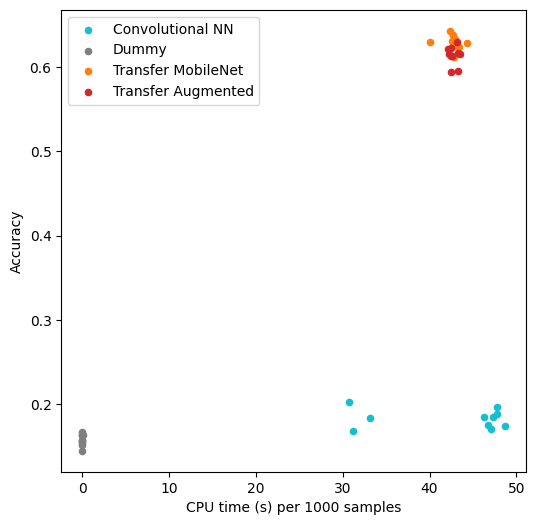

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = {'dummy':'tab:grey', 'svn':'tab:green', 'cnn':'tab:cyan', 'transfer':'tab:orange', 'transfer_augmented':'tab:red'}
labels = {'dummy':'Dummy', 'svn':'Support Vector Machine', 'cnn':'Convolutional NN', 'transfer':'Transfer MobileNet', 'transfer_augmented': 'Transfer Augmented'}
grouped = eval_pd.groupby('model')
for key,group in grouped:
    group.plot(ax=ax, kind='scatter', x='CPU_time', y='accuracy', label=labels[key], color=colors[key])
#ax.set_xscale('log')
ax.set_xlabel(f"CPU time (s) per {NUM_TEST_SAMPLES} samples")
ax.set_ylabel("Accuracy")
plt.legend()
plt.show()

### Averages per sample
Note that CPU time is cumulated over all CPUs used, so migt be larger than wall time.

In [26]:
avg_df = pd.DataFrame(columns=['model', 'average accuracy', 'average time'])
def get_eval_avg(model):
    acc_avg = eval_pd[eval_pd.model==model].accuracy.mean()
    time_avg = eval_pd[eval_pd.model==model].CPU_time.mean()/NUM_TEST_SAMPLES
    return acc_avg, time_avg
acc_avg, time_avg = get_eval_avg('dummy')
avg_df.loc[len(avg_df)] = {'model': 'Dummy' , 'average accuracy': acc_avg, 'average time': time_avg}
#acc_avg, time_avg = get_eval_avg('svn')
#avg_df.loc[len(avg_df)] = {'model': 'Support Vector Machine' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('cnn')
avg_df.loc[len(avg_df)] = {'model': 'Convolutional NN' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('transfer')
avg_df.loc[len(avg_df)] = {'model': 'Transfer MobileNet' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('transfer_augmented')
avg_df.loc[len(avg_df)] = {'model': 'Transfer Augmented' , 'average accuracy': acc_avg, 'average time': time_avg}

In [27]:
avg_df

,model,average accuracy,average time
0,Dummy,0.1581,0.000003
1,Convolutional NN,0.1831,0.042676
2,Transfer MobileNet,0.6292,0.042685
3,Transfer Augmented,0.6135,0.042758
